# 0. Marking.

**_IMPORTANT_**: Save a copy of this notebook into your Drive before you start.

- Please attempt all the questions marked for your group (Part II ✅ | Part III/MPhil ✅).

Please submit a zip file, containing both parts, consiting of of:

1. A text file with a publicly visible link to your notebooks in Google Colab or GitHub.
2. A downloaded copy (ipynb) of your notebooks or your zipped cloned GitHub repo. You may treat these as a report: we will not be re-executing the code you used to produce the answers unless required.

If you find yourself enjoying the material, feel free to attempt more! Provide your answers in a new cell below the question cell.


## Imports


In [1]:
# The simulation component of flower uses RAY under the hood.
# `pip` could produce some errors. Nothing to worry about.
# The execution has been verified; it is working anyway.
! pip install --quiet --upgrade "pip"
! pip install --quiet \
    git+https://github.com/Iacob-Alexandru-Andrei/flower.git@teaching ray=="2.6.3" \
    torch=="2.2.1" torchvision=="0.17.1"  tqdm=="4.67.1" torchsummary \
    pycrypto cryptography pycryptodome matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 147.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Imports
import os
import random
from collections.abc import Callable
from typing import Any
from pathlib import Path

import flwr as fl
import numpy as np

import torch
from flwr.client import Client
from flwr.common.typing import NDArrays
from flwr.server import ServerConfig, History
from flwr.server.strategy import Strategy
from enum import IntEnum
from datetime import datetime, timezone
import json


# Add new seeds here for easy autocomplete
class Seeds(IntEnum):
    """Seeds for reproducibility."""

    DEFAULT = 1337


np.random.seed(Seeds.DEFAULT)
random.seed(Seeds.DEFAULT)
torch.manual_seed(Seeds.DEFAULT)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

PathType = Path | str | None

### Paths


In [3]:
home_dir = Path.cwd()
data_dir: Path = home_dir / "data"

### Useful Python functions


In [4]:
def convert(o: Any) -> int | float:
    """Convert input object to Python numerical if numpy."""
    # type: ignore[reportGeneralTypeIssues]
    if isinstance(o, np.int32 | np.int64):
        return int(o)
    # type: ignore[reportGeneralTypeIssues]
    if isinstance(o, np.float32 | np.float64):
        return float(o)
    raise TypeError


def save_history(hist: History, name: str) -> None:
    """Save history from simulation to file."""
    time = int(datetime.now(timezone.utc).timestamp())
    path = home_dir / "histories"
    path.mkdir(exist_ok=True)
    path = path / f"hist_{time}_{name}.json"
    with open(path, "w", encoding="utf-8") as f:
        json.dump(hist.__dict__, f, ensure_ascii=False, indent=4, default=convert)


def start_seeded_simulation(
    client_fn: Callable[[str], Client],
    num_clients: int,
    config: ServerConfig,
    strategy: Strategy,
    name: str,
    seed: int = Seeds.DEFAULT,
    iteration: int = 0,
) -> tuple[list[tuple[int, NDArrays]], History]:
    """Wrap simulation to always seed client selection."""
    np.random.seed(seed ^ iteration)
    torch.manual_seed(seed ^ iteration)
    random.seed(seed ^ iteration)
    parameter_list, hist = fl.simulation.start_simulation_no_ray(
        client_fn=client_fn,
        num_clients=num_clients,
        client_resources={},
        config=config,
        strategy=strategy,
    )
    save_history(hist, name)
    return parameter_list, hist

### Dataset


In [5]:
from common.client import get_flower_client_generator
from common.client_utils import (
    get_network_generator_cnn,
    get_model_parameters,
)

In [6]:
np.random.seed(Seeds.DEFAULT)
random.seed(Seeds.DEFAULT)
torch.manual_seed(Seeds.DEFAULT)
network_generator_cnn = get_network_generator_cnn()
seed_net_cnn = network_generator_cnn()
seed_model_cnn_params: NDArrays = get_model_parameters(seed_net_cnn)
federated_evaluation_function = None

In [7]:
fl_client_gen = get_flower_client_generator(network_generator_cnn, home_dir, home_dir)

# Secure Aggregation


In this section, we will explore a **Secure Multi-Party Computation (SMPC)** based approach first implemented in an FL context in [this](https://arxiv.org/abs/1611.04482) paper, called **Secure Aggregation**.
The authors proposed a protocol for the secure aggregation of model updates in a Federated Learning setting.
SMPC algorithms allow a group of _mutually distrustful parties_ to compute a function over their private inputs without revealing any information about their inputs to one another.
In Federated Learning, users can compute the average of their model updates without revealing any information about their model updates to the other actors.
This is achieved by a complex exchange of encrypted keys and messages between the actors, which is why the protocol is _computationally expensive_.
The additional information the server and clients exchanges results in additional _communication overhead_.
In this Lab, we will focus on the communication overhead, ignoring the computational overhead. Furthermore, the protocol requires a specific fraction of clients to complete training to compute the average.

[Pan Heng](https://github.com/panh99) implemented the first Secure Aggregation in Flower. Thus, we will use part of his code in this section. However, because of the complexity of this protocol, we refer all the discussions to the original paper.
The main takeaways from the paper are the following: private inputs of clients are completely protected in this setting; Secure Aggregation is computationally expensive and requires a lot of communication overhead; the scalability of Secure Aggregation to many clients requires a lot of computational resources.

In the following cell, we will download the code for the Secure Aggregation protocol.


In [8]:
secagg_dir = home_dir / "secagg"

The implementation contains many encryption utilities, and thus it is very complex.
So, feel free to dig into the code, but be aware that it is unnecessary to understand every part of it to complete the Lab.

We also need to create a folder to store the keys generated on the fly by our simulation.


In [9]:
keys_dir = secagg_dir / "client_data"
keys_dir.mkdir(exist_ok=True, parents=True)

We are now importing the relevant functions for simulating the Secure Aggregation protocol from the files we have just downloaded.


In [10]:
from common.secagg.client import get_sec_agg_client_generator as get_client_generator
from common.secagg.strategy import SecureAggregationStrategy

It is important to point out that from now on we will use a toy simulator.
This means that we will not use real clients, so we are not training anything.
We will just simulate the communication between the server and the clients to explore the communication overhead.
The scripts are built to return to the `aggregate_fit` function of the server the length of the bytes exchanged during all the phases of communication of the Secure Aggregation protocol.
The equivalent single FL training round is achieved in 4 phases of communication by the protocol.

It is worth mentioning that for this implementation we will change our training round from using epochs to local steps because we need all the clients to train on the same amount of data samples.
This is done because even the number of samples could be considered sensitive information that we do not want to reveal to the other actors.


In [11]:
num_total_clients = 3290

In [12]:
def run_sec_agg_demo(
    num_clients_per_round: int = 10,
    n_model_parameters: int = 10000,
    min_num_surviving_clients: int = 5,
    n_rounds: int = 2,
    n_samples: int = 30,
) -> Any:
    """Execute a secure aggregation simulation."""
    strategy = SecureAggregationStrategy(
        n_dim=n_model_parameters,
        num_clients_per_round=num_clients_per_round,
        threshold=min_num_surviving_clients,
        num_dropouts=num_clients_per_round - min_num_surviving_clients,
    )
    secagg_hist = start_seeded_simulation(
        client_fn=lambda cid: get_client_generator(
            n_model_parameters, n_samples, keys_dir
        )(cid).to_client(),
        num_clients=num_total_clients,
        # this refers to the number of phases to simulate (must be 4*n_rounds)
        config=ServerConfig(num_rounds=int(4 * n_rounds)),
        strategy=strategy,
        name=f"secagg_{num_clients_per_round}_{n_model_parameters}_{min_num_surviving_clients}_{n_rounds}_{n_samples}",
    )
    # Clean up keys from the folder
    for filename in os.listdir(keys_dir):
        file_pth = keys_dir / filename
        if filename.endswith(".pth"):
            Path.unlink(file_pth)

    return secagg_hist

In the next cell, we will simulate the Secure Aggregation protocol defined by the abovementioned parameters.


In [14]:
parameters_for_every_round, secagg_hist = run_sec_agg_demo()

INFO flwr 2025-02-20 10:27:41,858 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=8, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=8, round_timeout=None)
INFO flwr 2025-02-20 10:27:41,878 | server_returns_parameters.py:81 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2025-02-20 10:27:41,881 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2025-02-20 10:27:41,882 | server_returns_parameters.py:84 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
INFO flwr 2025-02-20 10:27:41,887 | server_returns_parameters.py:97 | FL starting
INFO:flwr:FL starting
INFO flwr 2025-02-20 10:27:41,889 | strategy.py:120 | Configure fit: stage 0, 0, True
INFO:flwr:Configure fit: stage 0, 0, True
INFO flwr 2025-02-20 10:27:41,892 | strategy.py:126 | Stage 0
INFO:flwr:Stage 0
DEBUG fl

In [15]:
secagg_hist

History (metrics, distributed, fit):
{'total_cost': [(1, 4500), (2, 79160), (3, 401340), (4, 14430), (5, 4500), (6, 79160), (7, 401340), (8, 14430)]}

Looking carefully at the `History` object returned by the simulation, we can see that it contains the key `total_cost`, which couples the round of communication with the number of bytes exchanged during that round.
Note that the values are periodic because of the 4 phases involved in the protocol.


**Question 9 (Part II ✅ | Part III/MPhil ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

Using the function `run_SA_demo`, study the impact of different parameters on the `total_cost`:

1. Draw a scatter plot with the `total_cost` summed across rounds on the y-axis. While keeping all other parameters constant to the above values, vary the `num_clients_per_round` from 10 to 40 using an increment of 10. Use the `num_clients_per_round` as the x-axis.

2. Draw a scatter plot with the `total_cost` summed across rounds on the y-axis. While keeping all other parameters constant to the above values, vary `n_model_parameters` between $2^{10}$ and $2^{15}$ increasing using all the powers of two in the interval. Use the `n_model_parameters` as the x-axis.

3. Describe the trade-offs you see and how they relate to communication overheads.


**Questions 9 Answer:**

Part 1:

In [22]:
client_cost_data = {}
for num_clients_per_round in range(10, 50, 10):
  result = run_sec_agg_demo(num_clients_per_round=num_clients_per_round)
  total_cost = np.array(result[1].metrics_distributed_fit['total_cost'])[:,1]
  client_cost_data[num_clients_per_round] = np.sum(total_cost)

INFO flwr 2025-02-20 15:32:26,233 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=8, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=8, round_timeout=None)
INFO flwr 2025-02-20 15:32:26,250 | server_returns_parameters.py:81 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2025-02-20 15:32:26,255 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2025-02-20 15:32:26,258 | server_returns_parameters.py:84 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
INFO flwr 2025-02-20 15:32:26,260 | server_returns_parameters.py:97 | FL starting
INFO:flwr:FL starting
INFO flwr 2025-02-20 15:32:26,262 | strategy.py:120 | Configure fit: stage 0, 0, True
INFO:flwr:Configure fit: stage 0, 0, True
INFO flwr 2025-02-20 15:32:26,263 | strategy.py:126 | Stage 0
INFO:flwr:Stage 0
DEBUG fl

In [24]:
num_clients= list(client_cost_data.keys())
client_costs = [client_cost_data[key] for key in num_clients]

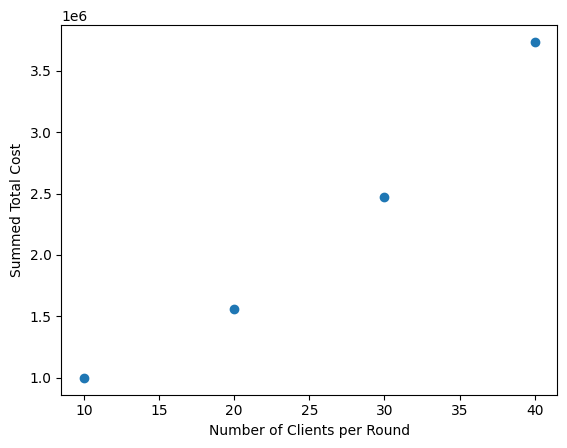

In [26]:
import matplotlib.pyplot as plt
plt.scatter(x=num_clients, y=client_costs)
plt.xlabel("Number of Clients per Round")
plt.ylabel("Summed Total Cost")
plt.show()


Part 2:

In [30]:
parameter_cost_data = {}
for pow in range(10, 16):
    num_model_parameters=2**pow
    result = run_sec_agg_demo(n_model_parameters=num_model_parameters)
    total_cost = np.array(result[1].metrics_distributed_fit['total_cost'])[:,1]
    parameter_cost_data[num_model_parameters] = np.sum(total_cost)


INFO flwr 2025-02-20 15:41:59,007 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=8, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=8, round_timeout=None)
INFO flwr 2025-02-20 15:41:59,032 | server_returns_parameters.py:81 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2025-02-20 15:41:59,037 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2025-02-20 15:41:59,040 | server_returns_parameters.py:84 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
INFO flwr 2025-02-20 15:41:59,042 | server_returns_parameters.py:97 | FL starting
INFO:flwr:FL starting
INFO flwr 2025-02-20 15:41:59,044 | strategy.py:120 | Configure fit: stage 0, 0, True
INFO:flwr:Configure fit: stage 0, 0, True
INFO flwr 2025-02-20 15:41:59,046 | strategy.py:126 | Stage 0
INFO:flwr:Stage 0
DEBUG fl

In [31]:
num_params= list(parameter_cost_data.keys())
params_costs = [parameter_cost_data[key] for key in num_params]

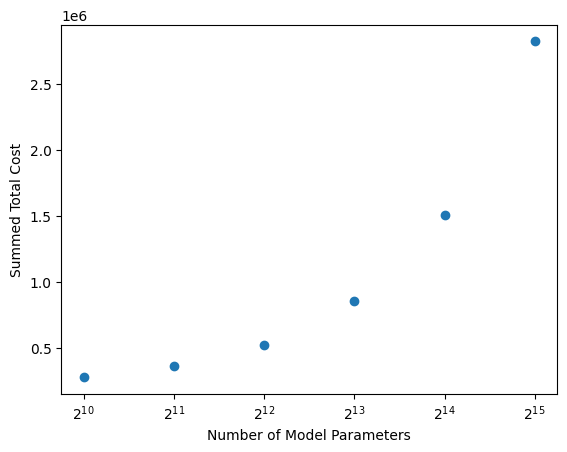

In [32]:
plt.scatter(x=num_params, y=params_costs)
plt.xscale('log', base=2)
plt.xlabel("Number of Model Parameters")
plt.ylabel("Summed Total Cost")
plt.show()

Part 3:

The graphs present a clear trade-off in terms of cost of communication and the number of model parameters as well as the number of clients used during a round. Increasing either of these parametes result an exponential increase in communication cost. Therefore, when it comes to FL in communication restricted environments using Secure Aggregation, we might need to make a decision whether we want to train a larger model or with more clients per round or find a balance between both. In an setting where communication is not restricted we still need to consider the effect of these values when using Secure Aggregation as it might effect the speed of convergence and could amplify negative behaviours such a late model updates and the periodic client behaviours.

---

**Question 10 (Part III/MPhil ✅):**

(This is a purely conceptual question. Answer in **no more than 10 sentences each**.)

After reading the [paper](https://arxiv.org/abs/1611.04482) and experimenting with the additional communication costs of Secure Aggregation in FL, discuss the implication of using this protocol in a real FL setting. You may want to discriminate between cross-silo and cross-device settings. You can focus on communication and computation overheads and refer to the asymptotic complexity of both.


---

**Question 10 Answer:**

To understand to effect os Secure Aggregation in a real FL setting we need separate whether a the system is in a cross-silo or cross-device setting. The use of the proposed algorithm would increase the computation and communication cost on the client side with the complexity of O($n^2 +kn$) and O(n+k) respectively where n is the number of clients and k is number of model parameters. In a cross-device setting clients might dropout during a training round due to their network conditions, battery life or other external reasons which is not as common in a cross-silo setting as they tend to be more stable. Therefore increasing the computational and communication cost in a cross-device setting might result in otherwise available data to be lost due to the additional overhead. Consequently, to use secure aggregation with a large number of client in a cross-device setting the number of model parameters should be kept low compared to the number of clients as it increases computational costs on the client side by $n^2$. Additionally the larger number of clients would also require more computational resources available to the server as the computational cost complexity there is O($kn^2$) and the communication cost is O($n^2$ + kn) where both increased by the square of the number of clients. Although the computational cost is greatly affected by the number of clients, communication cost is equally influenced by the number of clients and model parameters allowing a balance between both when it comes to round configuration. On the other hand, in a cross-silo setting where clients can be assumed to be more stable and fewer, we can train models with more parameters as well as use less powerful servers.

---

(c) 2024 Alexandru-Andrei Iacob, Lorenzo Sani
